In [1]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import ufl

fe.set_log_level(13)

# --------------------
# Functions and classes
# --------------------
mesh = fe.Mesh("mesh.xml")
#triangularized mesh is 1x1
x = mesh.coordinates()
scaling_factor =24
x[:, 0] *= 24
x[:, 1] *= 12
#scale to 24 length x 12 width

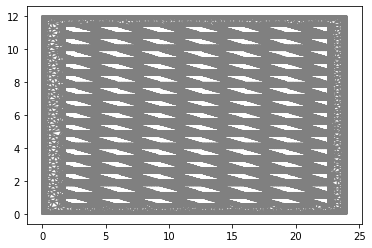

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


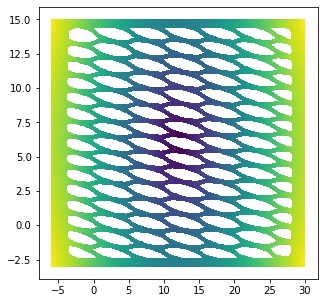

In [3]:
mi_x,mi_y=np.min(mesh.coordinates(),axis=0)
ma_x,ma_y=np.max(mesh.coordinates(),axis=0)
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)




bottom=fe.AutoSubDomain(lambda x: fe.near(x[1],mi_y,eps=.01))
bottom.mark(boundaries,1)

left=fe.AutoSubDomain(lambda x: fe.near(x[0],mi_x,eps=.01))
left.mark(boundaries,1)

right=fe.AutoSubDomain(lambda x: fe.near(x[0],ma_x,eps=.01))
right.mark(boundaries,1)

top=fe.AutoSubDomain(lambda x: fe.near(x[1],ma_y,eps=.01)) #bottom of mesh
top.mark(boundaries,1)


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    lmbda=E*0.48/((1+0.3)*(1-2*0.3))
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

move_x,move_y=(ma_x-mi_x)/4., (ma_y-mi_y)/4.

# --------------------
# Parameters
# --------------------
# Lame's fe.Constants
#lmbda = 1.25
#mu = 20

E = 3000.0 # young modulus in mm units, 3 Mpa real units.
mu = E/(2*(1+0.3))


# --------------------
# Geometry
# --------------------





fe.plot(mesh)
plt.show()

# Definition of Neumann condition domain


# top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))
# top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
u = fe.Function(V)

rho_0 = 1. #if body force is active
g = fe.Constant((0.0, 0.0)) #body gravity normal forces if needed for more complex simulations
b = fe.Constant((0.0, 0.0))
N = fe.Constant((0.0, 1.0))

aa, bb, cc, dd, ee = 0.5*mu, 0.0, 0.0, mu, -1.5*mu

# --------------------
# Boundary conditions
# --------------------
move_y=0
bc1 = fe.DirichletBC(V, fe.Expression(("0.5*(x[0]-12)","0.5*(x[1]-6)"), degree=1), bottom)
bc2 = fe.DirichletBC(V, fe.Expression(("0.5*(x[0]-12)","0.5*(x[1]-6)"), degree=1), left)
bc3 = fe.DirichletBC(V, fe.Expression(("0.5*(x[0]-12)","0.5*(x[1]-6)"), degree=1), top)
bc4 = fe.DirichletBC(V, fe.Expression(("0.5*(x[0]-12)","0.5*(x[1]-6)"), degree=1), right)


bcs=[bc1,bc2,bc3,bc4]
# --------------------
# Weak form
# --------------------
I = fe.Identity(2)
F = I + fe.grad(u)  # Deformation gradient
C = F.T*F  # Right Cauchy-Green tensor
J = fe.det(F)  # Determinant of deformation fradient

n = fe.dot(ufl.cofac(F), N)
surface_def = fe.sqrt(fe.inner(n, n))
psi = (aa*fe.inner(F, F) + ee - dd*fe.ln(J))*fe.dx - rho_0*J*fe.dot(b, u)*fe.dx + surface_def*fe.inner(g, u)*ds(1)

# --------------------
# Solver
# --------------------
Form = fe.derivative(psi, u, u_test)
Jac = fe.derivative(Form, u, u_tr)

problem = fe.NonlinearVariationalProblem(Form, u, bcs, Jac)
solver = fe.NonlinearVariationalSolver(problem)
prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 2E-6
prm['newton_solver']['relative_tolerance'] = 2E-5
prm['newton_solver']['maximum_iterations'] = 250
prm['newton_solver']['relaxation_parameter'] = 1.0


#prm["newton_solver"]["error_on_convergence"] = False
#fe.solve(Form == 0, u, bc, J=Jac, solver_parameters={"error_on_convergence": False})
solver.solve()


# --------------------
# Post-process
# --------------------
fig,ax=plt.subplots(1,1,figsize=(5,5))
fe.plot(u, mode="displacement")
plt.show()

In [4]:
file = fe.File("displacement_2.pvd");
file << u;

In [5]:
dFE = fe.FiniteElement("DG", mesh.ufl_cell(), 0)
tFE = fe.TensorElement(dFE)
W = fe.FunctionSpace(mesh, tFE)
stress = fe.Function(W, name='Stress')
stress.assign(fe.project(sigma(u), W))
file=fe.File("stress_2.pvd")
file << stress

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
dFE = fe.FiniteElement("DG", mesh.ufl_cell(), 0)
tFE = fe.TensorElement(dFE)
W = fe.FunctionSpace(mesh, tFE)
strain = fe.Function(W, name='strain')
strain.assign(fe.project(epsilon(u), W))
file=fe.File("strain_2.pvd")
file << strain